# Toxicity prediction by SMILES

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import resreg
import smogn
import xgboost
from deepchem import deepchem
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tdc.single_pred import Tox

## Data
### Download dataset

In [15]:
data = Tox(name="LD50_Zhu")
split = data.get_split()
train_raw, test_raw, val_raw = split["train"], split["test"], split["valid"]
print(f"train: {len(train_raw)}, val: {len(val_raw)}, test: {len(test_raw)}")
train_raw.head()

Found local copy...
Loading...
Done!


train: 5170, val: 738, test: 1477


,Drug_ID,Drug,Y
0,"Methane, tribromo-",BrC(Br)Br,2.343
1,Bromoethene (9CI),C=CBr,2.330
2,"1,1'-Biphenyl, hexabromo-",Brc1ccc(-c2ccc(Br)c(Br)c2Br)c(Br)c1Br,1.465
3,"Isothiocyanic acid, p-bromophenyl ester",S=C=Nc1ccc(Br)cc1,2.729
4,"Benzene, bromo-",Brc1ccccc1,1.765


<Axes: >

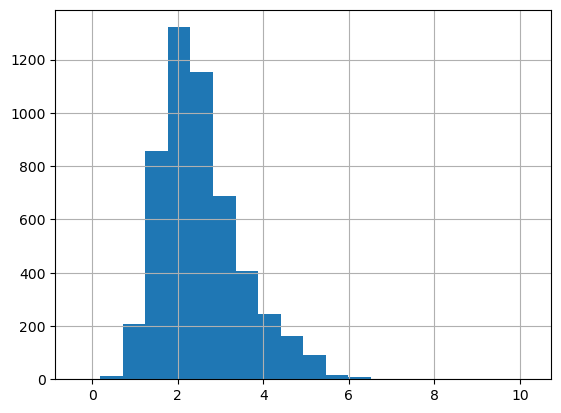

In [69]:
train_raw.Y.hist(bins=20) # imbalance!

### Prepare dataset

In [26]:
rdkit = deepchem.feat.RDKitDescriptors()
X_train = rdkit.featurize(train_raw.Drug.to_list())
X_test = rdkit.featurize(test_raw.Drug.to_list())
X_val = rdkit.featurize(val_raw.Drug.to_list())

np.save(open("data/features/rdkit_train.npy", "wb"), X_train)
np.save(open("data/features/rdkit_test.npy", "wb"), X_test)
np.save(open("data/features/rdkit_val.npy", "wb"), X_val)

In [27]:
y_train, y_test = train_raw.Y.to_list(), test_raw.Y.to_list()

In [130]:
relevance = resreg.sigmoid_relevance(y_train, cl=1.25, ch=3.5)
X_train_s, y_train_s = resreg.smoter(X_train, y_train, relevance=relevance)

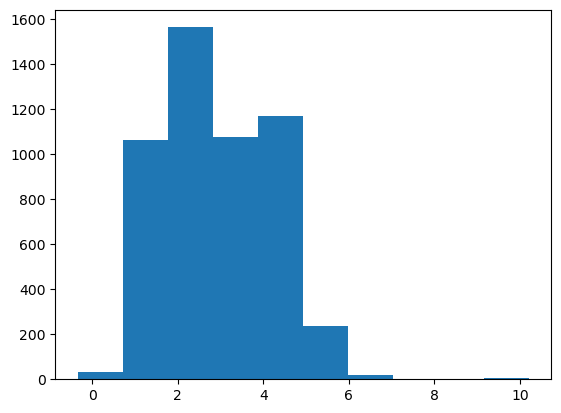

In [131]:
plt.hist(y_train_s)
plt.show()

In [31]:
val_set = list(zip(X_val, val_raw.Y.to_list()))

## Model

### Training

In [108]:
model = xgboost.XGBRegressor(n_estimators=100, max_depth=6, tree_method="hist", learning_rate=10e-2)

In [109]:
_ = model.fit(X_train, y_train, eval_set=[(X_train_s, y_train_s), (X_val, val_raw.Y.to_list())], eval_metric="mae", verbose=False)

### R2 score

In [110]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(train_score, test_score)

0.864950033945701 0.6078692418290459


### AUC plot

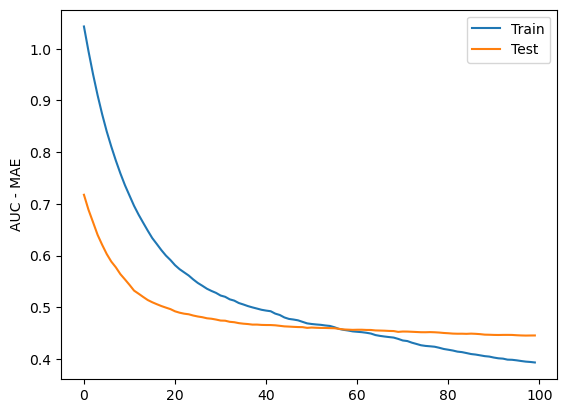

In [111]:
results = model.evals_result()
epochs = len(results["validation_0"]["mae"])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["mae"], label="Train")
ax.plot(x_axis, results["validation_1"]["mae"], label="Test")
ax.legend()
plt.ylabel("AUC - MAE")
plt.show()

### Test MAE

In [112]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"mae: {mae}, mse: {mse}")

mae: 0.4413351323561, mse: 0.35033283099889195


### Saving and loading model

In [113]:
model.save_model("data/model.json")

In [38]:
model2 = xgboost.XGBRegressor()
model2.load_model("data/model.json")

## Test on our data

In [39]:
ecbd = pd.read_excel("data/ecbd_all.xlsx")
ecbd.head()

,eos,smiles,inchi,inchikey,formula,mw,hba,hbd,tpsa,rb,fp3,logp,violates_ro5,pubchem,chembl,zinc
0,EOS1,COc1ccc(N2C(=O)NC(CC(=O)N3CCC(c4ccccc4)CC3)C2=...,InChI=1S/C23H25N3O4/c1-30-19-9-7-18(8-10-19)26...,BDSKOWUCRDTSBA-UHFFFAOYSA-N,C23H25N3O4,407.470001,7,1,78.949997,5,0.347826,2.91630,0,CID91820963,NaN,NaN
1,EOS2,COc1cc2ncn(CCC(=O)NCc3cccc(F)c3)c(=O)c2cc1OC,InChI=1S/C20H20FN3O4/c1-27-17-9-15-16(10-18(17...,BBHNGOSSYMSMBL-UHFFFAOYSA-N,C20H20FN3O4,385.394989,7,1,82.449997,7,0.250000,2.25930,0,CID39351211,NaN,ZINC000032103955
2,EOS3,O=C(C1CCCCC12OCCO2)N1CCOC(c2ccccc2)C1,InChI=1S/C19H25NO4/c21-18(16-8-4-5-9-19(16)23-...,FDNIQBQHPFKADZ-UHFFFAOYSA-N,C19H25NO4,331.411987,5,0,48.000000,2,0.631579,2.51980,0,CID118986097,NaN,NaN
3,EOS4,O=C(CCCC(=O)N1CCOC(c2ccccc2)C1)N1CCOC(c2ccccc2)C1,InChI=1S/C25H30N2O4/c28-24(26-14-16-30-22(18-2...,ACLWFALTINVVJH-UHFFFAOYSA-N,C25H30N2O4,422.524994,6,0,59.080002,6,0.440000,3.35690,0,CID118986099,NaN,NaN
4,EOS5,CC[C@@H](C)[C@@H](CO)NC(=O)Cc1c(C)c2ccc(O)cc2o...,InChI=1S/C18H23NO5/c1-4-10(2)15(9-20)19-17(22)...,WSIYPOIJJLVUDP-MEBBXXQBSA-N,C18H23NO5,333.384003,6,3,99.769997,6,0.444444,1.87272,0,CID91637070,NaN,ZINC000217689925


In [40]:
fir = pd.read_csv("data/FIR_file_for_EC50.csv")
fir.head()

,EOS,Concentration (uM),Inhibition (%)
0,EOS100028,50.00,98.004103
1,EOS100028,50.00,98.290370
2,EOS100028,16.25,96.909992
3,EOS100028,16.25,97.079382
4,EOS100028,5.00,89.661510


In [41]:
fir_smiles = fir.merge(ecbd[["eos", "smiles"]], how="inner", left_on="EOS", right_on="eos") # it is possible that there is no matching smiles
fir_smiles = fir_smiles[["EOS", "smiles"]]
fir_smiles = fir_smiles.drop_duplicates(subset="EOS")
fir_smiles.head()

,EOS,smiles
0,EOS100028,O=C1Nc2ccccc2/C1=C1\Nc2ccccc2\C1=N/O
16,EOS100057,Cc1ccc(O)cc1Nc1ccnc(Nc2cccc(C(N)=O)c2)n1
32,EOS100080,CCc1nc2c(C)cc(N3CCN(CC(=O)N4CC(O)C4)CC3)cn2c1N...
48,EOS100134,Nc1cc2c3ccccc3ccc2c2ccccc12
64,EOS100147,COc1c(O)cc2oc(-c3ccc(O)cc3)cc(=O)c2c1O


In [42]:
rdkit = deepchem.feat.RDKitDescriptors()
to_pred = rdkit.featurize(fir_smiles.smiles.to_list())

In [114]:
model = xgboost.XGBRegressor()
model.load_model("data/model.json")

In [115]:
predicted = model.predict(to_pred)

In [116]:
fir_smiles["toxicity"] = predicted
fir_smiles.head()

,EOS,smiles,toxicity
0,EOS100028,O=C1Nc2ccccc2/C1=C1\Nc2ccccc2\C1=N/O,2.351323
16,EOS100057,Cc1ccc(O)cc1Nc1ccnc(Nc2cccc(C(N)=O)c2)n1,2.450751
32,EOS100080,CCc1nc2c(C)cc(N3CCN(CC(=O)N4CC(O)C4)CC3)cn2c1N...,2.797910
48,EOS100134,Nc1cc2c3ccccc3ccc2c2ccccc12,2.038908
64,EOS100147,COc1c(O)cc2oc(-c3ccc(O)cc3)cc(=O)c2c1O,2.830247


In [117]:
to_save = fir_smiles[["EOS", "smiles", "toxicity"]]
to_save.to_csv("data/predictions.csv")